In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import random

In [58]:
data = []
with open("yelp_academic_dataset_review.json", "r") as f:
    for i, line in enumerate(f):
        if i >= 75000:
            break
        data.append(json.loads(line))
df = pd.DataFrame(data) 


In [59]:
review_df = df[['stars', 'text']].astype({'stars': int})
review_df

,stars,text
0,3,"If you decide to eat here, just be aware it is..."
1,5,I've taken a lot of spin classes over the year...
2,3,Family diner. Had the buffet. Eclectic assortm...
3,5,"Wow! Yummy, different, delicious. Our favo..."
4,4,Cute interior and owner (?) gave us tour of up...
...,...,...
74995,4,Very cool store!! I've never been to one of th...
74996,5,I have been meaning to write a review for this...
74997,5,This place has MIND-BLOWINGLY good tacos and f...
74998,3,They give you large snowball sizes for little ...


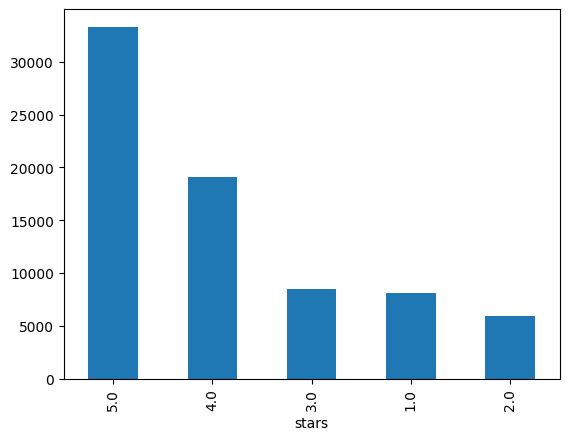

In [60]:
# inspect distribution of classes
df['stars'].value_counts().plot(kind='bar')
plt.show()

In [61]:
# randomly sample from each class based on how many samples the minority class holds
seed = 42
minority_class_count = len(review_df[review_df.loc[:, ('stars')] == 2])
review_df = review_df.groupby('stars').apply(lambda x: x.sample(n=minority_class_count, random_state=seed)).reset_index(drop=True)
review_df

,stars,text
0,1,"I, only gave 1 star because based on the appea..."
1,1,Wouldn't go here again..... I got my belly but...
2,1,Some of the reviews have mentioned how long it...
3,1,"Ok, I hate to give a place one star and I gene..."
4,1,i wish i could have given it a zero or a negat...
...,...,...
29840,5,Great place for drinks (I've never had food he...
29841,5,My girlfriend and I just had a delightful lunc...
29842,5,Gorgeous and stylish. Comfortable and clean. T...
29843,5,Had a great time at BR! Our server Reyna? was ...


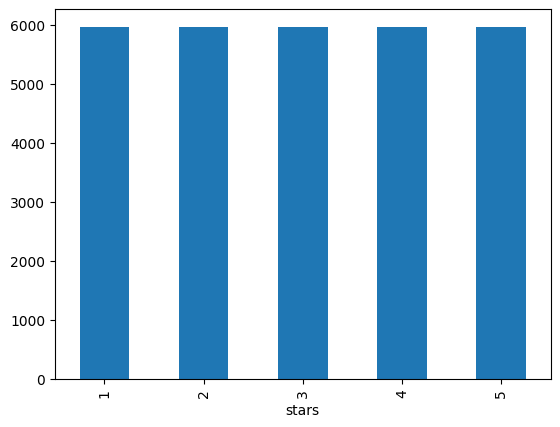

In [62]:
# inspect distribution of classes
review_df['stars'].value_counts().plot(kind='bar')
plt.show()

In [63]:
# transform data into pytorch tensors and tokenize
from torch.utils.data import Dataset, DataLoader
import torch
from transformers import AutoTokenizer
import tqdm

In [185]:
class ReviewDataSet(Dataset):
    """ torch Dataset for our review data """
    def __init__(self, dataframe):
        self.data = self.format_dataset(dataframe)



    """gives length of dataset"""
    def __len__(self) -> int:
        return len(self.data)
    
    """function allows object to be subscriptable -> dataset[0]"""
    def __getitem__(self, key):
        return self.data[key]
        
    
    def tokenize_text(self, text_data):
        token_dict = tokenizer(text_data, padding='max_length', truncation=True)
        input = torch.tensor(token_dict['input_ids'])
        token_type = torch.tensor(token_dict['token_type_ids'])
        att_mask = torch.tensor(token_dict['attention_mask'])
        return input, token_type, att_mask
    
    def format_dataset(self, dataframe: pd.DataFrame):
        self.data = {}
        input, token_type, att_mask = zip(*dataframe['text'].apply(self.tokenize_text))
        self.data['label'] = torch.tensor(dataframe['stars'].to_list())
        self.data['input_ids'] = input
        self.data['token_type_ids'] = token_type
        self.data['attention_mask'] = att_mask
        return self.data
        

In [186]:
review_dataset = ReviewDataSet(review_df)

In [192]:
# input for DataLoader needs to implement __getitem__() and __len__()
print(len(review_dataset))
print(review_dataset['label'])

dataloader = DataLoader(review_dataset, shuffle=True, batch_size=8)
dataloader.dataset['label']


# TODO: split into train and val set, then create model

4
tensor([1, 1, 1,  ..., 5, 5, 5])


tensor([1, 1, 1,  ..., 5, 5, 5])